In [2]:
# using Pkg
# Pkg.activate("..")
# Pkg.instantiate()
# Pkg.update()

  Activating project at `~/CropModeling/Garttuce`


    Updating registry at `~/.julia/registries/General.toml`


  No Changes to `~/CropModeling/Garttuce/Project.toml`
  No Changes to `~/CropModeling/Garttuce/Manifest.toml`


In [1]:
using Cropbox
using Test
# using Plots
using TimeZones
using DataFramesMeta
using CSV

# Cropbox.Interact.WebIO.setup(:ijulia)

In [2]:
include("../src/Garttuce.jl")

using Dates

┌ Warning: duplicate variable
│   system = Mass
│   name = living_total_mass
│   alias = nothing => nothing
│   state = :Track => :Track
└ @ Cropbox /home/cariso27001/.julia/packages/Cropbox/aE8bI/src/macro.jl:690


In [3]:
Lettuce = @config (
# # CV PHYL ILN GLN LL LER SG SD LTAR LTARa LIR Topt Tceil critPPD
# KM1 134 4 10 65.0 4.70 1.84 122 0 0.4421 0.1003 22.28 34.23 12
    :Phenology => (
        emergence_optimal_temperature = 15.0,
        emergence_ceiling_temperature = 28.0,
        optimal_temperature = 15, # Topt
        ceiling_temperature = 28, # Tceil
        critical_photoperiod = 24, # critPPD
        maximum_leaf_initiation_rate = 0.943214,
        maximum_emergence_rate = 0.02,
        maximum_phyllochron_asymptote = 0.802838,
        leaves_generic = 30, # GLN
    ),
    :Leaf => (
        maximum_elongation_rate = 4.7,
        minimum_length_of_longest_leaf = 26.4, # LL
        stay_green = 30,
        length_to_width_ratio = 0.8,
    ),
    :Carbon => (
# # Rm Yg
# 0.012 0.8
        maintenance_respiration_coefficient = 0.012, # Rm
        synthesis_efficiency = 0.8, # Yg
        partitioning_table = [
        # root leaf stem
          0.00 0.00 0.00 ; # seed garlic before germination
          0.15 0.60 0.25 ; # vegetative stage
          0.00 0.00 0.00 ; # dead
        ],
    ),
);

In [4]:
ConstructA = @config(Lettuce, (
    :Phenology => (
        planting_date = ZonedDateTime(2021, 10, 12, tz"Asia/Taipei"),
        emergence_date = ZonedDateTime(2021, 10, 24, tz"Asia/Taipei"),
    ),
    :Meta => (
        planting_group = 1,
        year = 2021,
    ),
    :Calendar => (
        init = ZonedDateTime(2021, 10, 12, 18, tz"Asia/Taipei"),
        last = ZonedDateTime(2021, 12, 19, tz"Asia/Taipei"),
    ),
    :Weather => (
        CO2 = 390,
        store = Garttuce.loadwea("$(@__DIR__)/../data/winter2021.wea", tz"Asia/Taipei"),
    ),
    :Plant => (initial_planting_density = 55,),
));

In [13]:
ConstructB = @config(Lettuce, (
    :Phenology => (
        planting_date = ZonedDateTime(2022, 3, 2, tz"Asia/Taipei"),
        emergence_date = ZonedDateTime(2022, 3, 16, tz"Asia/Taipei"),
    ),
    :Meta => (
        planting_group = 1,
        year = 2022,
    ),
    :Calendar => (
        init = ZonedDateTime(2022, 3, 2, 18, tz"Asia/Taipei"),
        last = ZonedDateTime(2022, 5, 28, tz"Asia/Taipei"),
    ),
    :Weather => (
        CO2 = 390,
        store = Garttuce.loadwea("$(@__DIR__)/../data/spring2022.wea", tz"Asia/Taipei"),
    ),
    :Plant => (initial_planting_density = 55,),
));

In [8]:
# obs_leafnum = CSV.read("$(@__DIR__)/../data/OBS_Winter2021/winter2021_leafnum_consistent.csv", DataFrame) |> unitfy

# f(s) = s.DAP' in obs_leafnum.DAP && Dates.hour(s.calendar.time') == 12

# # r = simulate(Garlic.Model;
# calibrate(Garttuce.Model, obs_leafnum;
#     config=ConstructA,
#     parameters= :Phenology => (;
#         LTARa_max = (0.1,1.5),
#         LIR_max = (0.2,1.5),
#     ),
#     stop="calendar.count",
#     index=:DAP,
#     target=:Appeared_mean => :leaves_appeared,
#     snap=f,
#     optim=(:MaxSteps => 3,),
# )

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps


11.31 secs, 4 evals, 2 steps, improv/step: 0.500 (last = 0.5000), fitness=5.664847811



Optimization stopped after 4 steps and 19.64 seconds
Termination reason: Max number of steps (3) reached
Steps per second = 0.20
Function evals per second = 0.36
Improvements/step = 0.66667
Total function evaluations = 7


Best candidate found: 

[0.653149, 0.663805]

Fitness: 2.046041585



LTARa_max,=,0.653149
LIR_max,=,0.663805


Progress:  31%[========>                  ]  ETA: 0:00:02 ( 2.04 ms/it)

Progress:  62%[================>          ]  ETA: 0:00:01 ( 2.04 ms/it)

Progress:  92%[========================>  ]  ETA: 0:00:00 ( 2.08 ms/it)

Progress: 100%[===========================] Time: 0:00:03 ( 2.08 ms/it)


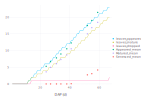

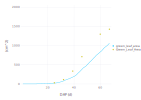

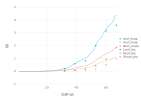

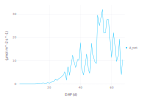

In [10]:
obs_drymass = CSV.read("$(@__DIR__)/../data/OBS_Winter2021/winter2021_DryMass.csv", DataFrame) |> unitfy
obs_area = CSV.read("$(@__DIR__)/../data/OBS_Winter2021/winter2021_Area.csv", DataFrame) |> unitfy
obs_leafnum = CSV.read("$(@__DIR__)/../data/OBS_Winter2021/winter2021_leafnum_consistent.csv", DataFrame) |> unitfy

r = simulate(Garttuce.Model;
    config=ConstructA,
    stop="calendar.count",
    snap=s -> Dates.hour(s.calendar.time') == 12,
)
@test r.leaves_initiated[end] > 0

sln = visualize(r, :DAP, [:leaves_appeared, :leaves_mature, :leaves_dropped], kind=:line) # Fig. Leaf Number
visualize!(sln, obs_leafnum, :DAP, [:Appeared_mean, :Matured_mean, :Senesced_mean]) |> display # Fig. Leaf Area
sa = visualize(r, :DAP, :green_leaf_area, kind=:line, ylim = (0,2000))
visualize!(sa, obs_area, :DAP, [:Green_Leaf_Area]) |> display # Fig. Leaf Area
sb = visualize(r, :DAP, [:leaf_mass, :root_mass, :stem_mass], kind=:line)
visualize!(sb, obs_drymass, :DAP, [:Leaf_dry, :Root_dry, :Shoot_dry]) |> display # Fig. Biomass
visualize(r, :DAP, [:A_net], kind=:line) |> display

Progress:  25%[======>                    ]  ETA: 0:00:03 ( 2.11 ms/it)

Progress:  48%[============>              ]  ETA: 0:00:02 ( 2.11 ms/it)

Progress:  71%[===================>       ]  ETA: 0:00:01 ( 2.13 ms/it)

Progress:  93%[=========================> ]  ETA: 0:00:00 ( 2.15 ms/it)

Progress: 100%[===========================] Time: 0:00:04 ( 2.15 ms/it)


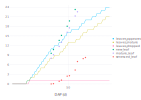

In [14]:
obs_leafnum = CSV.read("$(@__DIR__)/../data/OBS_Spring2022/spring2022_leafnum_inconsistent.csv", DataFrame) |> unitfy

r = simulate(Garttuce.Model;
    config=ConstructB,
    stop="calendar.count",
    snap=s -> Dates.hour(s.calendar.time') == 12,
)
@test r.leaves_initiated[end] > 0

sln = visualize(r, :DAP, [:leaves_appeared, :leaves_mature, :leaves_dropped], kind=:line) # Fig. Leaf Number
visualize!(sln, obs_leafnum, :DAP, [:new_leaf, :mature_leaf, :senesced_leaf]) |> display # Fig. Leaf Area


In [7]:
CSV.write("$(@__DIR__)/../SimExport.csv", r)

"/home/cariso27001/CropModeling/Garttuce/test/../SimExport.csv"

In [8]:
# Cropbox.Unitful.ustrip.(r)

In [17]:
evaluate(obs_leafnum, r; index = :DAP, target = :Appeared_mean => :leaves_appeared, metric=:ef) |> display
evaluate(obs_leafnum, r; index = :DAP, target = :Appeared_mean => :leaves_appeared, metric=:rmse) |> display
evaluate(obs_leafnum, r; index = :DAP, target = :Matured_mean => :leaves_mature, metric=:ef) |> display
evaluate(obs_leafnum, r; index = :DAP, target = :Matured_mean => :leaves_mature, metric=:rmse) |> display
evaluate(obs_leafnum, r; index = :DAP, target = :Senesced_mean => :leaves_dropped, metric=:ef) |> display
evaluate(obs_leafnum, r; index = :DAP, target = :Senesced_mean => :leaves_dropped, metric=:rmse) |> display

evaluate(obs_area, r; index = :DAP, target = :Green_Leaf_Area => :green_leaf_area, metric=:ef) |> display
evaluate(obs_area, r; index = :DAP, target = :Green_Leaf_Area => :green_leaf_area, metric=:rmse) |> display

evaluate(obs_drymass, r; index = :DAP, target = :Leaf_dry => :leaf_mass, metric=:ef) |> display
evaluate(obs_drymass, r; index = :DAP, target = :Leaf_dry => :leaf_mass, metric=:rmse) |> display
evaluate(obs_drymass, r; index = :DAP, target = :Shoot_dry => :shoot_mass, metric=:ef) |> display
evaluate(obs_drymass, r; index = :DAP, target = :Shoot_dry => :shoot_mass, metric=:rmse) |> display
evaluate(obs_drymass, r; index = :DAP, target = :Root_dry => :root_mass, metric=:ef) |> display
evaluate(obs_drymass, r; index = :DAP, target = :Root_dry => :root_mass, metric=:rmse) |> display

0.9629121176089072

0.9521516059279422

0.9566487764917632

0.988572571919288

-Inf

1.6050027483370162

0.8158552801185097

184.48725592955483 cm^2

0.7760460010255611

0.7628279064964095 g

-1.073596099589702

3.272409447404318 g

0.307585160020034

0.33532841321932005 g

In [ ]:
# Cropbox.Interact.WebIO.setup(:ijulia)

manipulate(Garttuce.Model, :DAP, [:leaves_appeared, :leaves_mature, :leaves_dropped, :leaves_detached, :leaves_real];
    config = ConstructB,
    parameters = :Phenology => (;
        optimal_temperature = 10:40,
        
    ),
    stop = "calendar.count",
    kind = :line,
)